# Benchmark QC

Benchmark different single cell ATAC-seq QC approaches. 
H5ad files should be preprocessed and the anndata.obs table should contain the qc-columns to filter on. Preprocessing is archived by executing preprocessing.ipynb. 

QC metrices tested:

    - TSSe
    - FRiP
    - Fragment count
    - Feature count
    - Doublets
    - Mito/Nuclei DNA
    - PEAKQC
    - Nucleosome score (muon)
    
 Embedding and filtering quality metrices to evaluate effects:
 
    - Residual Average Gini Index (RAGI)
    - Adjusted Rand Index (ARI)
    - Editing Distance Score (EDS)

In [1]:
"""HELPER FUNCTIONS."""
# Author: Jan Detleffsen (jan.detleffsen@mpi-bn.mpg.de)

import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, Manager
from functools import partial
from collections import OrderedDict
import time

def calculate_distances(adata, neighbours, cell_idx, highly_variable=False):
    """
    Calculate edited distances of the available features between a cell and its neighbours.
    The distance is normalized by the total counts of the features.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    neighbours : np.array
        Array of indices of the neighbours.
    cell_idx : int
        Index of the cell.

    Returns
    -------
    float
        Mean of the normalized distances.
    """
    
    # calculate the distances of the features between the cell and its neighbours
    # if the number of neighbours is larger than 0
    if len(neighbours) > 0:
        if highly_variable:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours][:, adata.var.highly_variable], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx][:, adata.var.highly_variable])
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours][:, adata.var.highly_variable] - adata.X[cell_idx][:, adata.var.highly_variable].toarray()[0]), axis=1)
            # change distance when there no highly variable features to 1
            zeros = np.where(total_counts == 0)
            # set the distances to 1
            distances[zeros] = 1
            # set the total counts to 1
            total_counts[zeros] = 1

        else:
            # calculate the total counts of the neighbours
            feature_counts = np.sum(adata.X[neighbours], axis=1)
            # calculate the total counts of the cell
            cell_count = np.sum(adata.X[cell_idx].toarray(), axis=1)[0]
            # calculate the total counts of the features
            total_counts = feature_counts + cell_count
            # calculate the distances of the features
            distances = np.sum(abs(adata.X[neighbours] - adata.X[cell_idx].toarray()[0]), axis=1)

        # normalize the distances by the total counts
        corrected_distances = distances / total_counts
        # calculate the mean of the normalized distances
        distance = np.mean(corrected_distances)
    # if there are no neighbours, set the distance to 1
    else:
        distance = 1

    return distance


def define_reference_cells(embedding, cell_idx, distance=False, n_cells=20):
    """
    Define the neighbours of a cell based on the Euclidean distance in the embedding space.

    Parameters
    ----------
    embedding : np.array
        Array of the embedding coordinates.
    cell_idx : int
        Index of the cell.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.

    Returns
    -------
    np.array
        Array of indices of the neighbours.
    """
    # extract the embedding coordinates of the cell
    cell_coordinates = embedding[cell_idx]
    # calculate the relative coordinates of the cell to all other cells
    relative_coordinates = embedding - cell_coordinates
    # calculate the distances of the cells to the cell
    distances = np.linalg.norm(relative_coordinates, axis=1)
    # find the indices of the cells that are closer than the distance
    if distance:
        # define the neighbours based on the distance
        indices_neighbours = np.array(np.where(distances <= distance))
        # define number of cells tom select
        n_cells = len(indices_neighbours)
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):]
    else:
        # define the neighbours based on the number of cells to consider
        indices_neighbours = np.argsort(distances)[:n_cells]
        # define most distant cells
        foreigners = np.argsort(distances)[-(n_cells-1):] # -1 to correct for seeding cell
    # remove the cell itself from the indices
    neighbours = indices_neighbours[np.where(indices_neighbours != cell_idx)]

    return neighbours, foreigners


def add_similarity(adata, distance=False, n_cells=20, embedding=None, threads=1, chunksize=50, highly_variable=False):
    """
    Add the similarity of the cells to the AnnData object.

    The similarity is calculated as the mean of the normalized distances of the available features between a cell and its neighbours.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    embedding : str, optional
        Key of the embedding coordinates in adata.obsm. If None, the UMAP coordinates are used. Default is None.
    threads : int, optional
        Number of threads to use for the calculation. Default is 1.
    chunksize : int, optional
        Number of cells to process in one chunk. Default is 50.

    Returns
    -------
    None
    """
    # extract the embedding coordinates
    if embedding is None:
        coordinates = adata.obsm['X_umap']
    else:
        coordinates = adata.obsm[embedding]

    # check if highly variable features are available
    if 'highly_variable' not in adata.var.keys():
        highly_variable = False

    # initialize the Pool with the number of threads and the maximum number of tasks per child
    pool = Pool(processes=threads, maxtasksperchild=threads)
    # initialize a Manager to share the results between the processes
    manager = Manager()
    # initialize a dictionary to store the similarities
    similarities = manager.dict()

    # initialize a list to store the results of the processes
    async_results = []
    # initialize a list to build the chunks
    chunk = []

    # Calculate total number of chunks for progress bar
    total_chunks = (len(coordinates) + chunksize - 1) // chunksize  # rounds up
    pbar = tqdm(total=total_chunks, desc="Computing chunks")

    # iterate over the cells in the embedding
    for cell_idx, cell_coordinates in enumerate(coordinates):
        # append the cell index and the embedding coordinates to the chunk
        chunk.append([cell_idx, cell_coordinates])
        # if the chunk is full
        if len(chunk) == chunksize:
            # process the chunk
            result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                      callback=partial(collect_result, similarities))
            # append the result to the list
            async_results.append(result)
            # clear the chunk
            chunk = []
            # update the progress bar
            pbar.update(1)
            # check if the number of running processes is larger than the number of threads
            while len(async_results) > 2 * threads:  # Adjust this ratio based on observed behavior and system specs
                # remove the finished processes
                async_results = [res for res in async_results if not res.ready()]
                # sleep for 1 second
                time.sleep(1)

    # remaining
    if len(chunk) != 0:
        result = pool.apply_async(process_chunk, args=(chunk, distance, n_cells, adata, coordinates, highly_variable),
                                  callback=partial(collect_result, similarities))
        async_results.append(result)
        pbar.update(1)

    for result in async_results:
        result.wait()

    pool.close()
    pool.join()

    similarities = dict(similarities)

    sorted_similarities = OrderedDict(sorted(similarities.items()))

    adata.obs['distance_score'] = np.fromiter(sorted_similarities.values(), dtype=float)


def collect_result(similarities, result):
    similarities.update(result)


def process_chunk(chunk, distance, n_cells, adata, coordinates, highly_variable=False):
    """
    process a chunk of cells to calculate the distance_score of the cells to their neighbours

    Parameters
    ----------
    chunk : list
        List of the cell indices and the embedding coordinates.
    distance : float
        Maximum distance in the embedding space to consider a cell as a neighbour.
    adata : AnnData
        Annotated data matrix.
    coordinates : np.array
        Array of the embedding coordinates.

    Returns
    -------
    dict
        Dictionary of the similarities.

    """
    sim_dict = {}
    for cell_idx, cell_coordinates in chunk:
        # define the reference cells
        neighbours, foreigners = define_reference_cells(coordinates, cell_idx, distance, n_cells)
        # calculate the distances of the features between the cell and its neighbours
        distance_n = calculate_distances(adata, neighbours, cell_idx, highly_variable=highly_variable)
        # calculate the distances of the features between the cell and the most distant cells
        distance_f = calculate_distances(adata, foreigners, cell_idx, highly_variable=highly_variable)
        # calculate the distance based score of the cell
        sim_dict[cell_idx] = 1/(distance_f+1) + distance_n

    return sim_dict


#define function to calculate Gini coefficient
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))


def calc_agi(adata, condition_column='cell_types_leiden_0.4'):
    
    adata_copy = adata.copy()
    conditions = adata_copy.obs[condition_column].unique()
    enrichment_columns = []

    for cond in conditions:

        # slice by cluster 
        adata_slice = adata_copy.obs_names[adata_copy.obs[condition_column] == str(cond)]
        subdata = adata_copy[adata_slice, :]
        # select all peaks available in the cluster 
        genes = subdata.var[subdata.layers['binary'].sum(axis=0).A1 > 1]
        # count abundances
        gene_counts = subdata.layers['binary'].sum(axis=0).A1[subdata.layers['binary'].sum(axis=0).A1 > 1]
        genes.loc[:, 'cluster_counts_' + str(cond)] = gene_counts
        # calc enrichment 
        genes['enrichment_' + str(cond)] = genes['cluster_counts_' + str(cond)] / genes['total_counts']
        # remove old tables
        # join results
        adata_copy.var = adata_copy.var.join(genes['cluster_counts_' + str(cond)])
        adata_copy.var = adata_copy.var.join(genes['enrichment_' + str(cond)])

        enrichment_columns.append('enrichment_' + str(cond))

    enrichments = adata_copy.var[enrichment_columns].values
    enrichments[np.isnan(enrichments)] = 0

    gini_coefficients = []
    for enrichment in enrichments:
        gini_coefficients.append(gini(enrichment))

    adata_copy.var[condition_column + '_' + 'gini'] = gini_coefficients

    return adata_copy

In [2]:
# Imports
import sctoolbox
import sctoolbox.tools.qc_filter as qc
import sctoolbox.utils as utils
import sctoolbox.tools as tools
import sctoolbox.plotting as pl

import matplotlib.pyplot as plt
import episcanpy as epi
import pandas as pd
import scrublet as scr
import os
import numpy as np
import scanpy as sc

In [43]:
# Sample
sample = 'right_atrium_auricular_region_IOBHN_ontology'

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

# Absolute minimum number of features for pre-selection of cells before QC 
min_genes = 1

# Choose whether to binarize the X matrix
binarize_mtx = False  # True or False; convert matrix to binary

#----------------------- Doublet removal ------------------------

# filter doublets
remove_doublets = False

# Use native scrublet or the scanpy wrapper (scanpy: optimized for RNA)
use_native_scrublet = True

# Default threshold to apply doublet removal on (None for automatic threshold)
doublet_threshold = 0.2
# Available threads
threads = 8

# Set default filter thresholds
# This will be applied to all samples - the thresholds can be changed manually when plotted 
use_default_thresholds = True  # set to False to ignore default_thresholds
thresholds = {
              #'n_features': {'min': 100, 'max': 5000},
              #'log1p_n_features': {'min': None, 'max': None},
              'fld_score': {'min': 100, 'max': 5000},
              #'frip': {'min': None, 'max': None},
              #'tsse_score': {'min': None, 'max': None}
              # add additional threshold based on the available columns shown above
              # format: '<obs clolumn>': {'min': <threshold|None>, 'max': <threshold|None>}
             }

# Removal of feature subsets
filter_chrM = True  # True or False; filtering out chrM
filter_xy = True    # True or False; filtering out chrX and chrY

# Highly Variable Features options 
select_highly_variable = True
min_cells = 5 # This one is mandatory
max_cells = None

# Choose normalization method
# TF-IDF: dimensionality is reduced by LSI
# Total: dimensionality is reduced by PCA 
norm_method = 'tfidf'  # can be 'tfidf' or 'total'

# Choose if highly variable features should be used
use_highly_variable = True

# Set number of neighbors
n_neighbors = 15

# UMAP related settings 
metacol = 'sample'  # some meta-column of interest. See tables above.
n_features = 'n_features'  # column name for the number of features. See tables above.

# number of PCs shown within the heatmap
n_pcs_heatmap = 30

# Whether PCs should be filtered
subset_pcs = True

corr_thresh = 0.70  # PCs with an absolut correlation above this will be filtered
perc_thresh = 30  # Top percentile of PCs that should be kept
filter_methods = ['cumulative variance', 'correlation']  # propose PCs based on the provided methods
basis = 'obs'  # base correlation on obs or var
ignore_cols = []  # List of column names to ignore for correlation

# Search embedding parameters
embedding = "umap"  # umap or tsne
search_parameters = True

n_components = 2  # Number of components for umap (>=3 enables 3d UMAP but likely degrades 2d results)

dist_range = (0.1, 0.31, 0.1)  # Set min_dist range for umap
spread_range = (1, 3.5, 0.5)  # Set spread range for umap

perplexity_range = (30, 60, 10)  # perplexity range for tsne
learning_rate_range = (400, 1000, 200)  # learning_rate for tsne

# Search different clustering resolutions
search_clustering_parameters = True
cluster_res_range = (0.1, 2, 0.1)  # Set the searched resolution range from low to high resolution (less to more clusters).
clustering_method = "leiden"  # leiden or louvain
cluster_ncols = 3  # Number of columns displayed in the plot

# Annotate regions to genes
GTF_PATH = '/mnt/flatfiles/organisms/new_organism/homo_sapiens/104/homo_sapiens.104.genes.gtf'  # genes gtf file

## 3 - Load anndata
Uses the anndata object written by the previous notebook.

In [4]:
work_dir = os.getcwd()

h5ad_path, current_dir = os.path.split(work_dir)

while current_dir != 'benchmarking':
    h5ad_path, current_dir = os.path.split(h5ad_path)
    
h5ad_path = os.path.join(h5ad_path, current_dir)
h5ad_path = os.path.join(h5ad_path, 'assembled')
h5ad_path = os.path.join(h5ad_path, f'{sample}.h5ad')

adata = utils.adata.load_h5ad(h5ad_path)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: /mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/assembled/right_atrium_auricular_region_IOBHN_ontology.h5ad


AnnData object with n_obs × n_vars = 73582 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'files', 'sctoolbox'

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCCGAGATA    28.0    21.0    21.0    21.0    1.0   
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTTTGCCGGAAGG     5.0     5.0     5.0     5.0    0.0   
TTCCATCCTCTTTGTGTTACCG   629.0   518.0   517.0   517.0   39.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTTGCCGGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGTGTTACCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal   fld_score  \
barcode                                                        
AAACTACCAGAAACCCGAGATA     MB           1.000000    0.003301   
AAACTACCAGAAACCTAAGTGG     MB           0.434524  305.939935   
...                       ...                ...         ...   
TTCCATCCTCTTTGCCGGAAGG     MB           1.000000    0.053747   
TTCCATCCTCTTTGTGTTACCG     MB           0.294118   40.761008   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCCGAGATA              117.23         13.0   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
...                                    ...          ...   
TTCCATCCTCTTTGCCGGAAGG              135.67          3.0   
TTCCATCCTCTTTGTGTTACCG              137.91        487.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCCGAGATA                         0.076923  0.384615    1.000000   
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
...                                                 ...       ...         ...   
TTCCATCCTCTTTGCCGGAAGG                         0.000000  0.333333    0.000000   
TTCCATCCTCTTTGTGTTACCG                         0.349076  0.336756    5.337278   

                        catlas_ov cell type closest Cell Ontology term(s)  
barcode                                                                    
AAACTACCAGAAACCCGAGATA      False       NaN                           NaN  
AAACTACCAGAAACCTAAGTGG      False       NaN                           NaN  
...                           ...       ...                           ...  
TTCCATCCTCTTTGCCGGAAGG      False       NaN                           NaN  
TTCCATCCTCTTTGTGTTACCG      False       NaN                           NaN  

[73582 rows x 17 columns]

peak_chr  peak_start  peak_end
name                                                 
chr1:10007-10565           chr1       10007     10565
chr1:11182-11364           chr1       11182     11364
...                         ...         ...       ...
chrY:56870833-56870955     chrY    56870833  56870955
chrY:56886632-56886906     chrY    56886632  56886906

[105042 rows x 3 columns]

In [5]:
# Ensure that condition column is a category
adata.obs[condition_column] = adata.obs[condition_column].astype("category")

### 4.2 - Remove empty cells and features

In [6]:
print('original shape:')
print(adata.shape)
print('Removing empty features and cells...')

adata = adata[adata.X.sum(axis=1) > 0]
adata = adata[:, adata.X.sum(axis=0) > 0]

print('new shape:')
print(adata.shape)

original shape:
(73582, 105042)
Removing empty features and cells...
new shape:
(69471, 101651)


### 4.4 - Binarize matrix
Binarizes the count matrix to be either 0 or 1. This corresponds to the general view that chromatin is either accessible (1) or inaccesible (0). However, it is still under debate whether binarization may result in a loss of information. Therefore,  binarization is optional.

**DOI: [10.1038/s41592-023-02112-6](https://doi.org/10.1038/s41592-023-02112-6)**

In [7]:
# save raw matrix
adata.layers["raw"] = adata.X.copy()
# binarize
if binarize_mtx:
    print("binarizing...")
    epi.pp.binarize(adata)
    # unique_values = np.unique(np.round(np.array(adata.X.todense()),2))
    print(f"unique values: {unique_values}")

### 4.5 Calculate and remove doublets
Doublets are artifacts where two (doublet) or more (multiplet) cells receive the same barcode. As multiplets behave as a joined feature set of the collected cells they may show up as a separate group in downstream analysis, thus potentially skewing results. Therefore, it is recommended to remove doublets.

**DOI: [10.1016/j.cels.2018.11.005](https://doi.org/10.1016/j.cels.2018.11.005)**

In [8]:
if remove_doublets:
    tools.qc_filter.estimate_doublets(adata, 
                                      use_native=use_native_scrublet, 
                                      groupby=condition_column, 
                                      threads=threads, 
                                      threshold=doublet_threshold)

In [9]:
if remove_doublets:
    # Remove the duplicates from adata
    tools.qc_filter.filter_cells(adata, "predicted_doublet", name="doublet")

In [10]:
# remove empty features
adata = adata[adata.X.sum(axis=1) > 0]
adata = adata[:, adata.X.sum(axis=0) > 0]

### 4.6 - Cell filtering
<hr style="border:1px solid black"> </hr>

Identify low quality cells and remove them from the dataset. Low quality cells are investigated using several metrics, which can be choosen below.

In [11]:
# Recalculate standard QC metrics (counts...)
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

# Remove peaks with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

In [12]:
# available obs columns
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata.obs)

TN      UM      PP      UQ     CM  \
barcode                                                         
AAACTACCAGAAACCCGAGATA    28.0    21.0    21.0    21.0    1.0   
AAACTACCAGAAACCTAAGTGG  7116.0  6025.0  6011.0  6011.0  218.0   
...                        ...     ...     ...     ...    ...   
TTCCATCCTCTTTGCCGGAAGG     5.0     5.0     5.0     5.0    0.0   
TTCCATCCTCTTTGTGTTACCG   629.0   518.0   517.0   517.0   39.0   

                                                                     file  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
AAACTACCAGAAACCTAAGTGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
...                                                                   ...   
TTCCATCCTCTTTGCCGGAAGG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   
TTCCATCCTCTTTGTGTTACCG  /mnt/workspace2/jdetlef/peakqc_paperprep/bench...   

                       sample  nucleosome_signal   fld_score  \
barcode                                                        
AAACTACCAGAAACCCGAGATA     MB           1.000000    0.003301   
AAACTACCAGAAACCTAAGTGG     MB           0.434524  305.939935   
...                       ...                ...         ...   
TTCCATCCTCTTTGCCGGAAGG     MB           1.000000    0.053747   
TTCCATCCTCTTTGTGTTACCG     MB           0.294118   40.761008   

                        mean_fragment_size  n_fragments  \
barcode                                                   
AAACTACCAGAAACCCGAGATA              117.23         13.0   
AAACTACCAGAAACCTAAGTGG              132.91       5861.0   
...                                    ...          ...   
TTCCATCCTCTTTGCCGGAAGG              135.67          3.0   
TTCCATCCTCTTTGTGTTACCG              137.91        487.0   

                        fold_change_promoters_fragments      frip  tsse_score  \
barcode                                                                         
AAACTACCAGAAACCCGAGATA                         0.076923  0.384615    1.000000   
AAACTACCAGAAACCTAAGTGG                         0.163795  0.112779    1.513383   
...                                                 ...       ...         ...   
TTCCATCCTCTTTGCCGGAAGG                         0.000000  0.333333    0.000000   
TTCCATCCTCTTTGTGTTACCG                         0.349076  0.336756    5.337278   

                        catlas_ov cell type closest Cell Ontology term(s)  \
barcode                                                                     
AAACTACCAGAAACCCGAGATA      False       NaN                           NaN   
AAACTACCAGAAACCTAAGTGG      False       NaN                           NaN   
...                           ...       ...                           ...   
TTCCATCCTCTTTGCCGGAAGG      False       NaN                           NaN   
TTCCATCCTCTTTGTGTTACCG      False       NaN                           NaN   

                        n_features  log1p_n_features  
barcode                                               
AAACTACCAGAAACCCGAGATA           8          2.197225  
AAACTACCAGAAACCTAAGTGG         482          6.180017  
...                            ...               ...  
TTCCATCCTCTTTGCCGGAAGG           1          0.693147  
TTCCATCCTCTTTGTGTTACCG         155          5.049856  

[69471 rows x 19 columns]

In [13]:
obs_columns = list(thresholds.keys())

groupby = condition_column if global_threshold is False else None
initial_thresholds = tools.qc_filter.get_thresholds(adata,
                                                    thresholds, 
                                                    groupby=groupby)
tools.qc_filter.thresholds_as_table(thresholds)

Parameter  Minimum  Maximum
0  fld_score      100     5000

In [14]:
_ = pl.qc_filter.upset_plot_filter_impacts(adata, 
                                           thresholds=initial_thresholds, 
                                           groupby=groupby,
                                           limit_combinations=2)

[INFO] Skipping UpSet Plot as only one threshold is given.



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#e41a1c'` for the same effect.



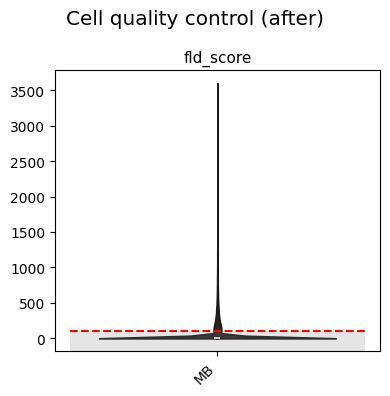

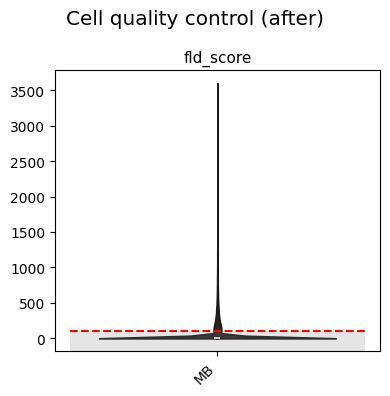

In [15]:
#Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    columns=obs_columns,
    groupby=condition_column,
    which="obs", 
    ncols=3,
    thresholds=thresholds,
    global_threshold = global_threshold,
    title="Cell quality control (after)",
    save="cell_filtering_final.pdf"
)
figure 


In [16]:
plt.close()

In [17]:
tools.qc_filter.apply_qc_thresholds(adata, thresholds, overwrite=True)

[INFO] Filtered 59155 elements from AnnData.obs (69471 -> 10316).


In [18]:
# remove empty features after cell filtering
adata = adata[:, adata.X.sum(axis=0) > 0]


Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#e41a1c'` for the same effect.



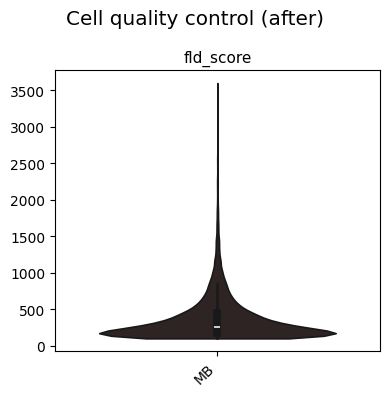

In [19]:
#Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    columns=obs_columns,
    groupby=condition_column,
    which="obs", ncols=3,
    global_threshold = global_threshold,
    title="Cell quality control (after)",
    save="cell_filtering_final.pdf"
)
figure 

In [20]:
plt.close()

## 5 - Feature processing
<hr style="border:2px solid black"> </hr>

This section filters features (peaks). The user has the option to remove features located on the mitochondrial chromosome and features on either of the allosomes. Additionally, features can be reduced to highly variable features (features with high differences between cells).

In [21]:
if filter_chrM:
    print("Removing chromosomal features...")
    non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
    adata = adata[:, non_m]
    
if filter_xy:
    print("Removing gender related features...")
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

Removing chromosomal features...
Removing gender related features...


### 5.2 - Select highly variable features

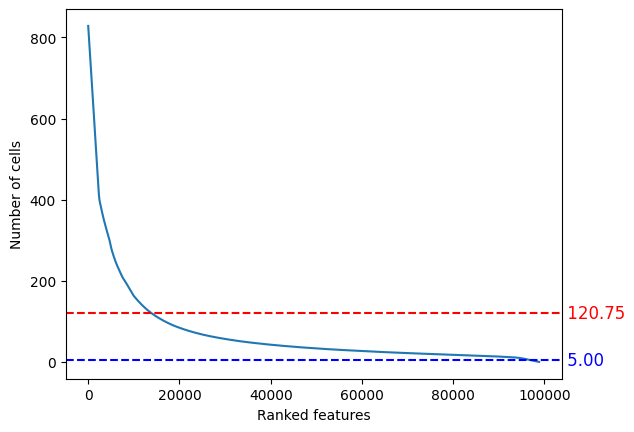

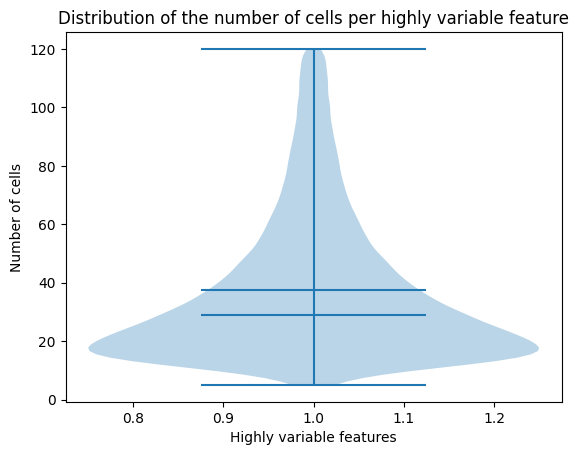

In [22]:
# update number of cells per feature
adata = tools.qc_filter.calculate_qc_metrics(adata, var_type='features')

# drop total_counts as it is the same as n_features
adata.obs.drop(columns=["total_counts", "log1p_total_counts"], inplace=True)

if select_highly_variable:
    # get highly variable features
    tools.highly_variable.get_variable_features(adata, max_cells, min_cells)
    #Number of variable genes selected
    adata.var["highly_variable"].sum()
    # plot HVF violin
    pl.highly_variable.violin_HVF_distribution(adata)

## 5 - Normalization
<hr style="border:2px solid black"> </hr>

This section performs the selected normalization method followed by a dimension reduction. The counts for each cell are normalized so that all cells have the same number of counts after normalization. This removes imbalances in sequencing depth to make the cells comparable.

The normalization method can be either TF-IDF or total count normalization. Term frequency-inverse document frequencies (TF-IDF), initially adopted by search engines, scores each variable (here open chromatin region) by their importance. It compares the frequency of a variable within a cell against the global occurrence over all cells thus highlighting cell defining variables. On the other hand, total count normalization adjusts the total count of each cell so that all cells have the same total count after normalization. A method frequently used for single cell RNA data.

After normalization a dimension reduction is computed, which depending on the normalization is either latent semantic indexing (LSI) for TF-IDF or principal component analysis (PCA) for total count. However, while differing in details both reduction methods are analogous and thus the following steps are the same independent of the chosen method. Since TF-IDF has been shown to be particularly effective for ATAC-seq data, it is used here as the default method.  
**DOI: [10.1038/nature25981](https://doi.org/10.1038/nature25981)**

In [23]:
# Save raw layer before normalization
adata.layers["raw"] = adata.X.copy()

In [24]:
adata = tools.norm_correct.normalize_adata(adata, norm_method, use_highly_variable=use_highly_variable)

[INFO] Performing TFIDF and LSI...


## 6 - Dimension reduction and neighbor graph
<hr style="border:2px solid black"> </hr>
Another important property of our data is its high dimensionality. However, this complexity hinders in-depth analysis e.g. the identification of cell states. Thus, dimension reduction algorithms are applied to reduce complexity while simultaneously retaining patterns, a crucial step to enable embedding and clustering. In other words, noise is reduced by removing low variance components as well as components explaining technical or otherwise unwanted factors (e.g. number of active genes, cell cycle, etc.) which also has the benefit of reducing the computational demand. Here the applied algorithms are either Principal Component Analysis (PCA) or Latent Semantic Indexing (LSI). The applied dimension reduction depends on the chosen normalization with total count using PCA and TF-IDF using LSI. For convenience, results of both methods are called principal components (PCs) in the following analysis steps.

**DOI: [10.1038/nmeth.4346](https://doi.org/10.1038/nmeth.4346)**  
**DOI: [10.1038/nature25981](https://doi.org/10.1038/nature25981)**

The following heatmaps and barplots are intended to identify potentially unwanted PCs by showing the PCs in combination with available observations (cell-related metrics) and variables (feature-related metrics). In general, **selected PCs should avoid correlations with metrics**, but the importance of metrics and the stringency of thresholds depends on the experiment and the underlying questions, and therefore requires careful consideration by the analyst.

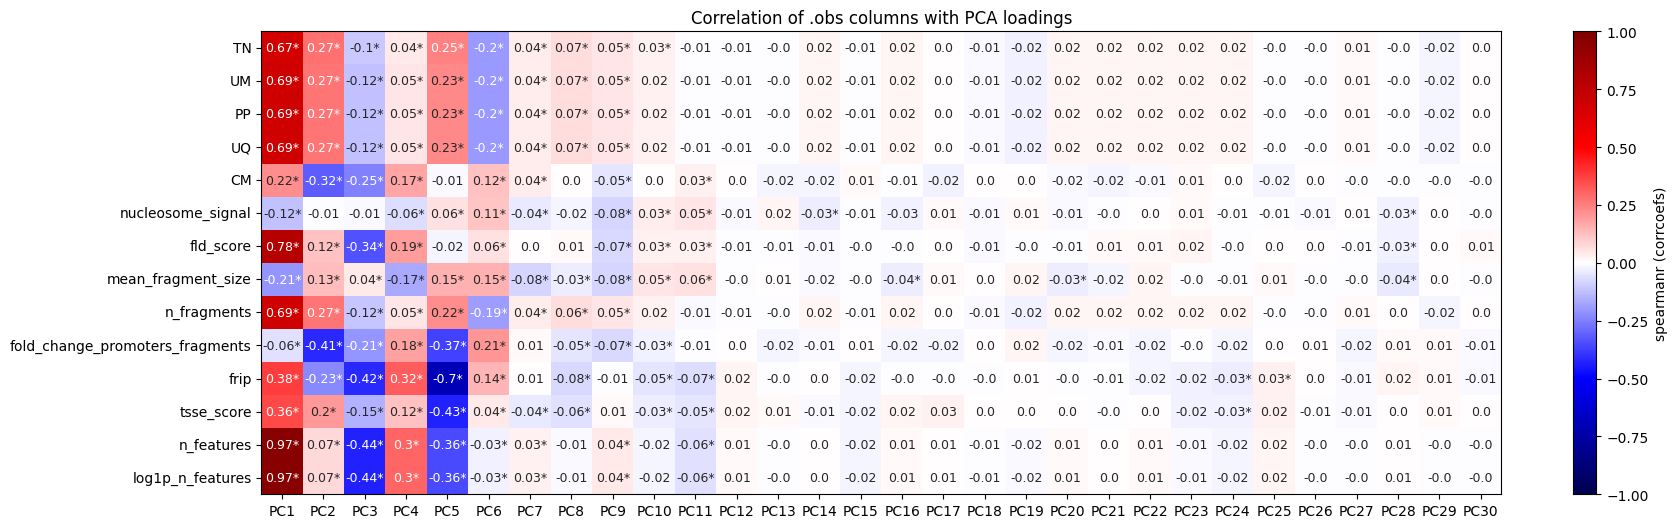

In [25]:
 # PCA correlations with obs variables 
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="obs",
    title="Correlation of .obs columns with PCA loadings",
    save="PCA_correlation_obs.pdf"
)
plt.show()

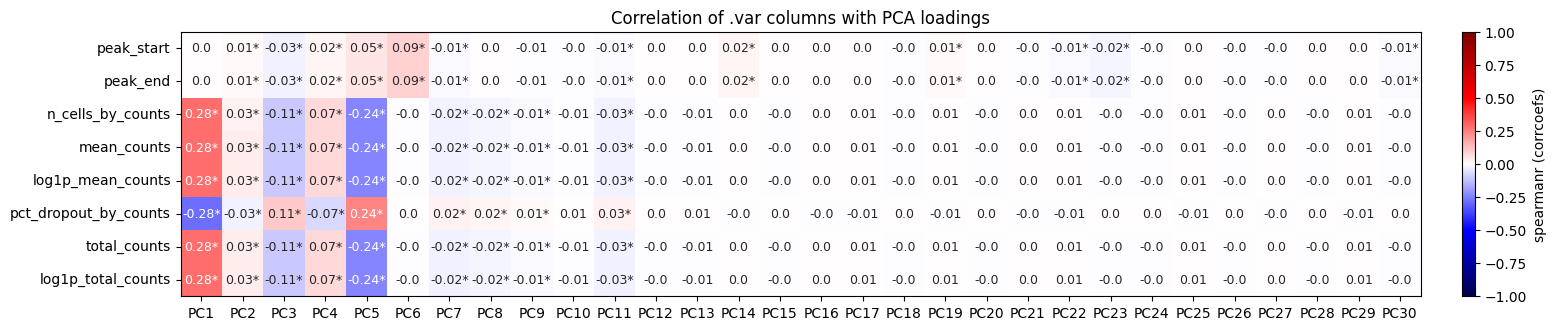

In [26]:
 # PCA correlations with var variables
_ = pl.embedding.plot_pca_correlation(
    adata,
    n_components=n_pcs_heatmap,
    which="var",
    title="Correlation of .var columns with PCA loadings",
    save="PCA_correlation_var.pdf"
)
plt.show()

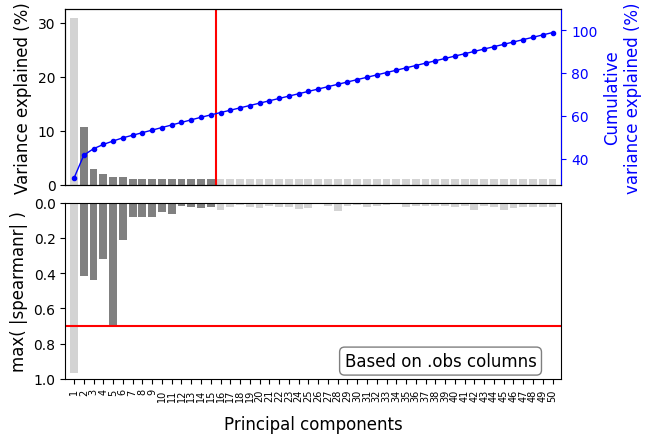

In [27]:
selected_pcs = tools.dim_reduction.propose_pcs(
    anndata=adata,
    how=filter_methods,
    corr_thresh=corr_thresh,
    perc_thresh=perc_thresh,
    corr_kwargs={'method': 'spearmanr', 'which': basis, 'ignore': ignore_cols}
)

# Plot and select number of PCs
_ = pl.embedding.plot_pca_variance(
    adata, 
    save='PCA_variance_proposed_selection.pdf',
    selected=selected_pcs,
    n_pcs=50,
    n_thresh=max(selected_pcs),
    corr_plot='spearmanr',
    corr_thresh=corr_thresh,
    corr_on=basis,
    ignore=ignore_cols
)
plt.show()

In [28]:
final_pc_selection = selected_pcs

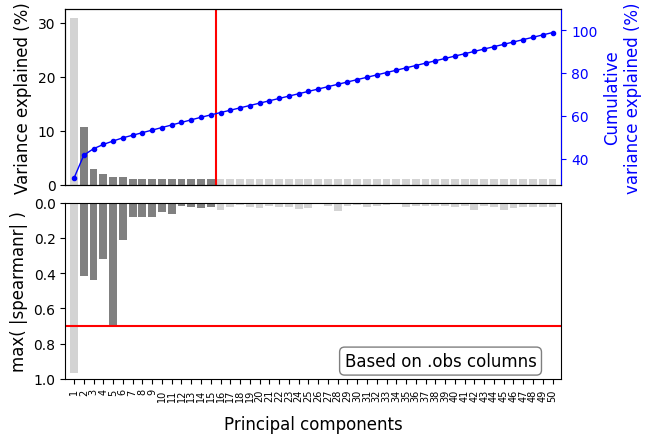

In [29]:
 _ = pl.embedding.plot_pca_variance(
    adata, 
    selected=final_pc_selection if subset_pcs else None,
    save='PCA_variance_final_selection.pdf',
    n_pcs=50,
    n_thresh=max(selected_pcs) if subset_pcs else None,
    corr_plot='spearmanr',
    corr_thresh=corr_thresh if subset_pcs else None,
    corr_on=basis,
    ignore=ignore_cols
)
plt.show()

In [30]:
# Subset the number of pcs if chosen in the parameters
if subset_pcs:
    tools.dim_reduction.subset_PCA(adata, select=final_pc_selection)

In [31]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', metric='euclidean')

## 7 - Calculate UMAP/TSNE and find the best setting
<hr style="border:2px solid black"> </hr>

After visually inspecting the results, adjust the parameters shown below for the best embedding. While it is somewhat subjective what the "best" parameters for an embedding should be, the chosen embedding should display clear structures that are neither spread too thin nor too clumped up.

Computing UMAPs:   0%|          | 0/15 [00:00<?, ?it/s]

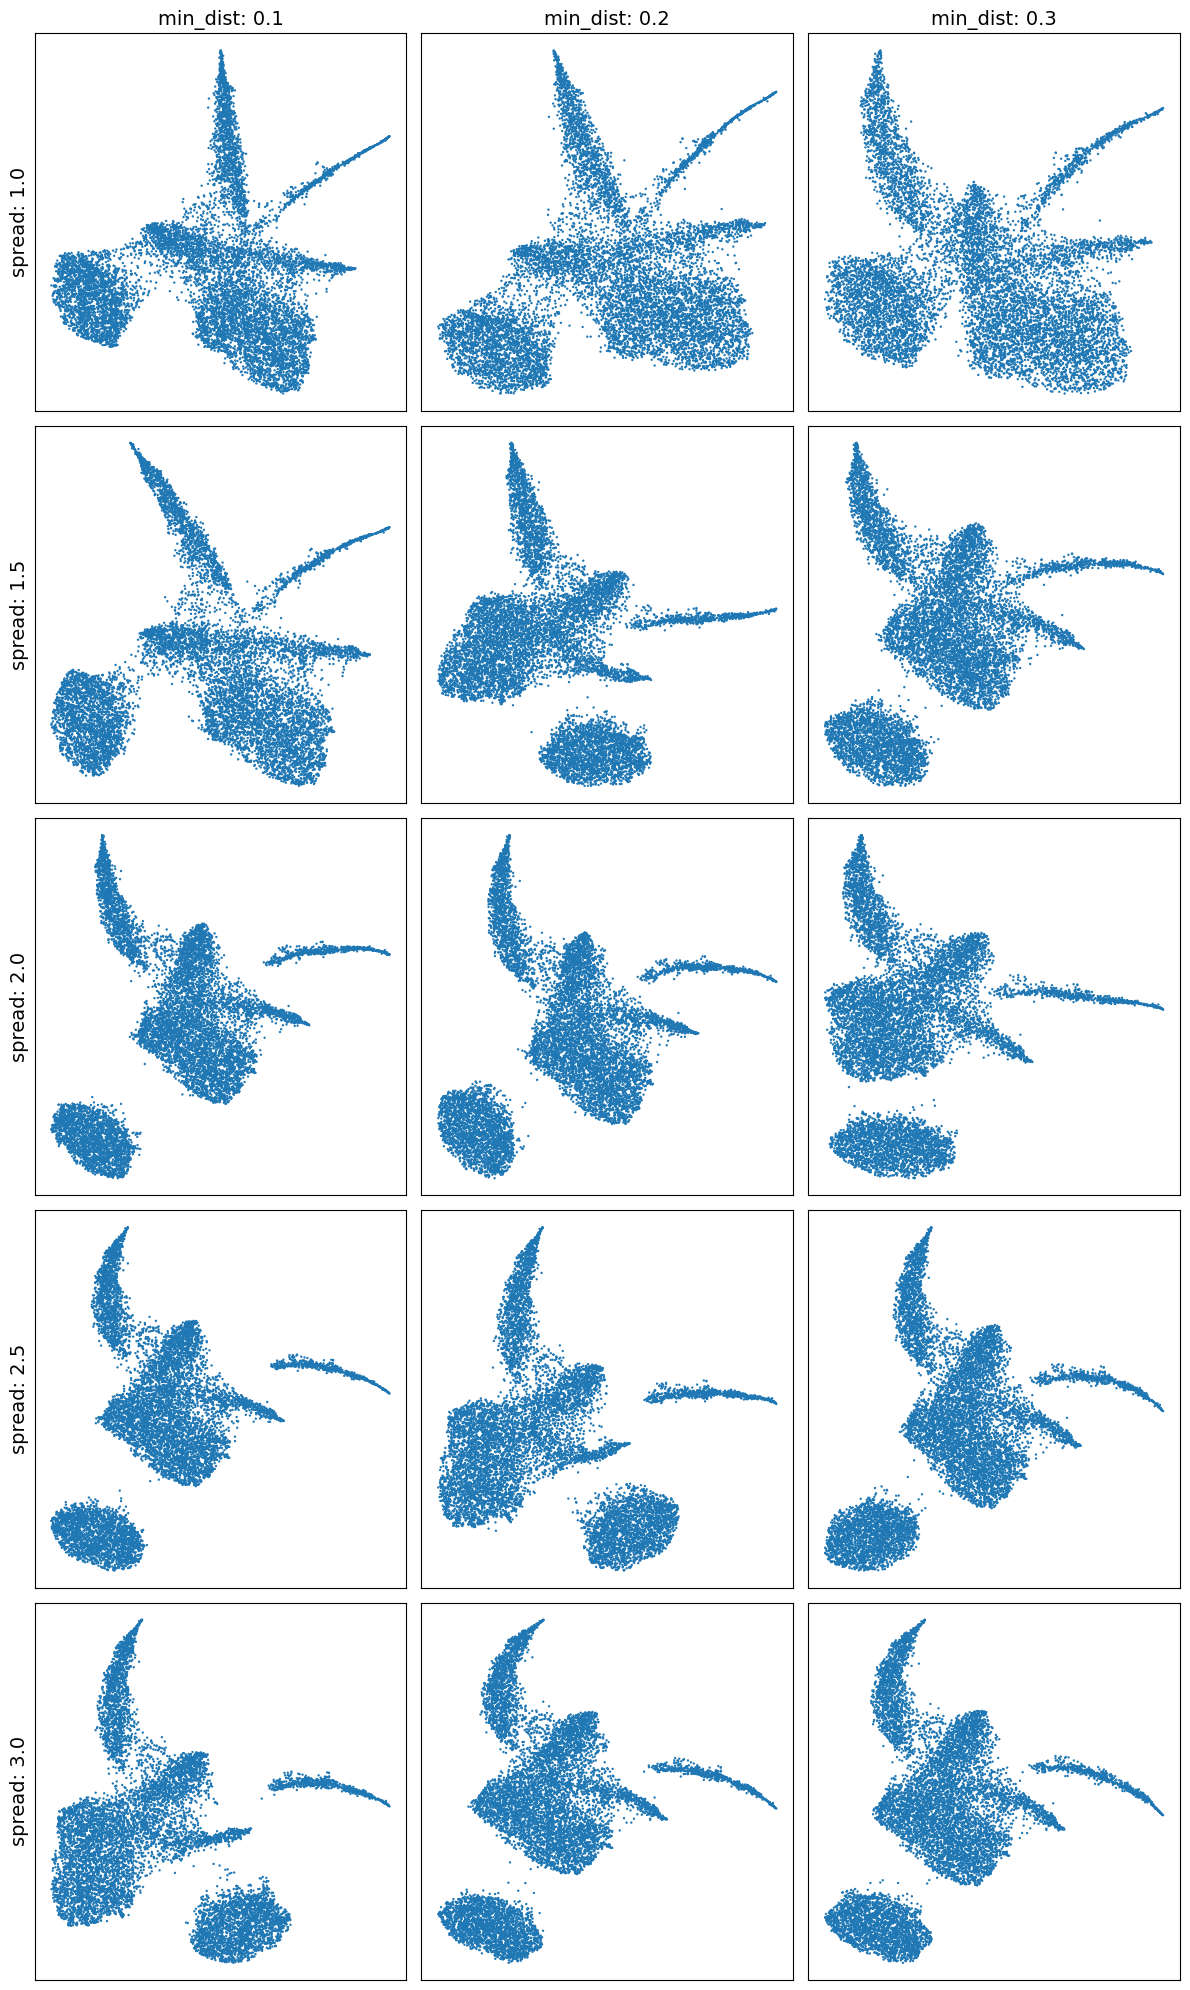

In [32]:
if search_parameters:
    if embedding == "umap":
        pl.embedding.search_umap_parameters(
            adata, 
            min_dist_range=dist_range,
            spread_range=spread_range,
            color=condition_column,
            n_components=n_components,
            threads=threads,
            save="UMAP_parameter_search.pdf"
        )
    elif embedding == "tsne":
        pl.embedding.search_tsne_parameters(
            adata, 
            perplexity_range=perplexity_range,
            learning_rate_range=learning_rate_range,
            color=condition_column,
            threads=threads,
            save="TSNE_parameter_search.pdf"
        )
    plt.show()

In [33]:
# Final choice of spread / dist for umap
min_dist = 0.1
spread = 1.0

# Final choice of perplexity_range / perplexity_range for tsne
perplexity = 50
learning_rate = 800

In [34]:
# Calculate final embedding
if embedding == "umap":
    sc.tl.umap(adata, min_dist=min_dist, spread=spread, n_components=n_components)
elif embedding == "tsne":
    sc.tl.tsne(adata, perplexity=perplexity, learning_rate=learning_rate)

## 8 - Cell clustering
<hr style="border:2px solid black"> </hr>

This step assigns each cell into a cluster. Cells in the same cluster are assumed to be of the same cell type. Cells are assigned based on their distance within the nearest neighbor graph, which is loosely equivalent to their distance within the embedding. The resolution controls the coarseness of the clustering. A lower resolution results in fewer larger clusters, while a higher resolution results in more smaller clusters.

- `clustering_column`: To choose a resolution, change the number in `leiden_0.5`, for example `leiden_0.1` for a resolution of `0.1`. Higher values lead to more clusters.

[INFO] Plotting umap for resolution=0.1 (1 / 19)
[INFO] Plotting umap for resolution=0.2 (2 / 19)
[INFO] Plotting umap for resolution=0.3 (3 / 19)
[INFO] Plotting umap for resolution=0.4 (4 / 19)
[INFO] Plotting umap for resolution=0.5 (5 / 19)
[INFO] Plotting umap for resolution=0.6 (6 / 19)
[INFO] Plotting umap for resolution=0.7 (7 / 19)
[INFO] Plotting umap for resolution=0.8 (8 / 19)
[INFO] Plotting umap for resolution=0.9 (9 / 19)
[INFO] Plotting umap for resolution=1.0 (10 / 19)
[INFO] Plotting umap for resolution=1.1 (11 / 19)
[INFO] Plotting umap for resolution=1.2 (12 / 19)
[INFO] Plotting umap for resolution=1.3 (13 / 19)
[INFO] Plotting umap for resolution=1.4 (14 / 19)
[INFO] Plotting umap for resolution=1.5 (15 / 19)
[INFO] Plotting umap for resolution=1.6 (16 / 19)
[INFO] Plotting umap for resolution=1.7 (17 / 19)
[INFO] Plotting umap for resolution=1.8 (18 / 19)
[INFO] Plotting umap for resolution=1.9 (19 / 19)


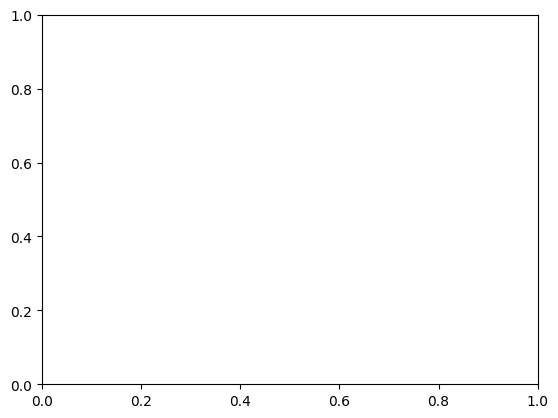

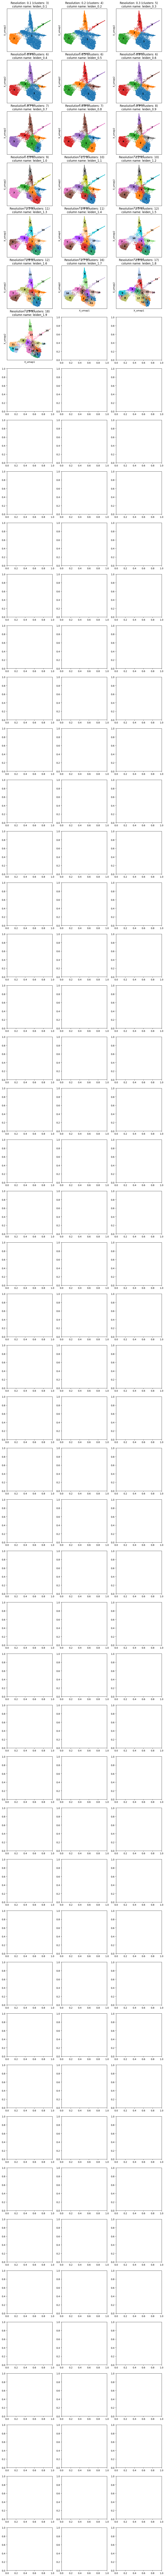

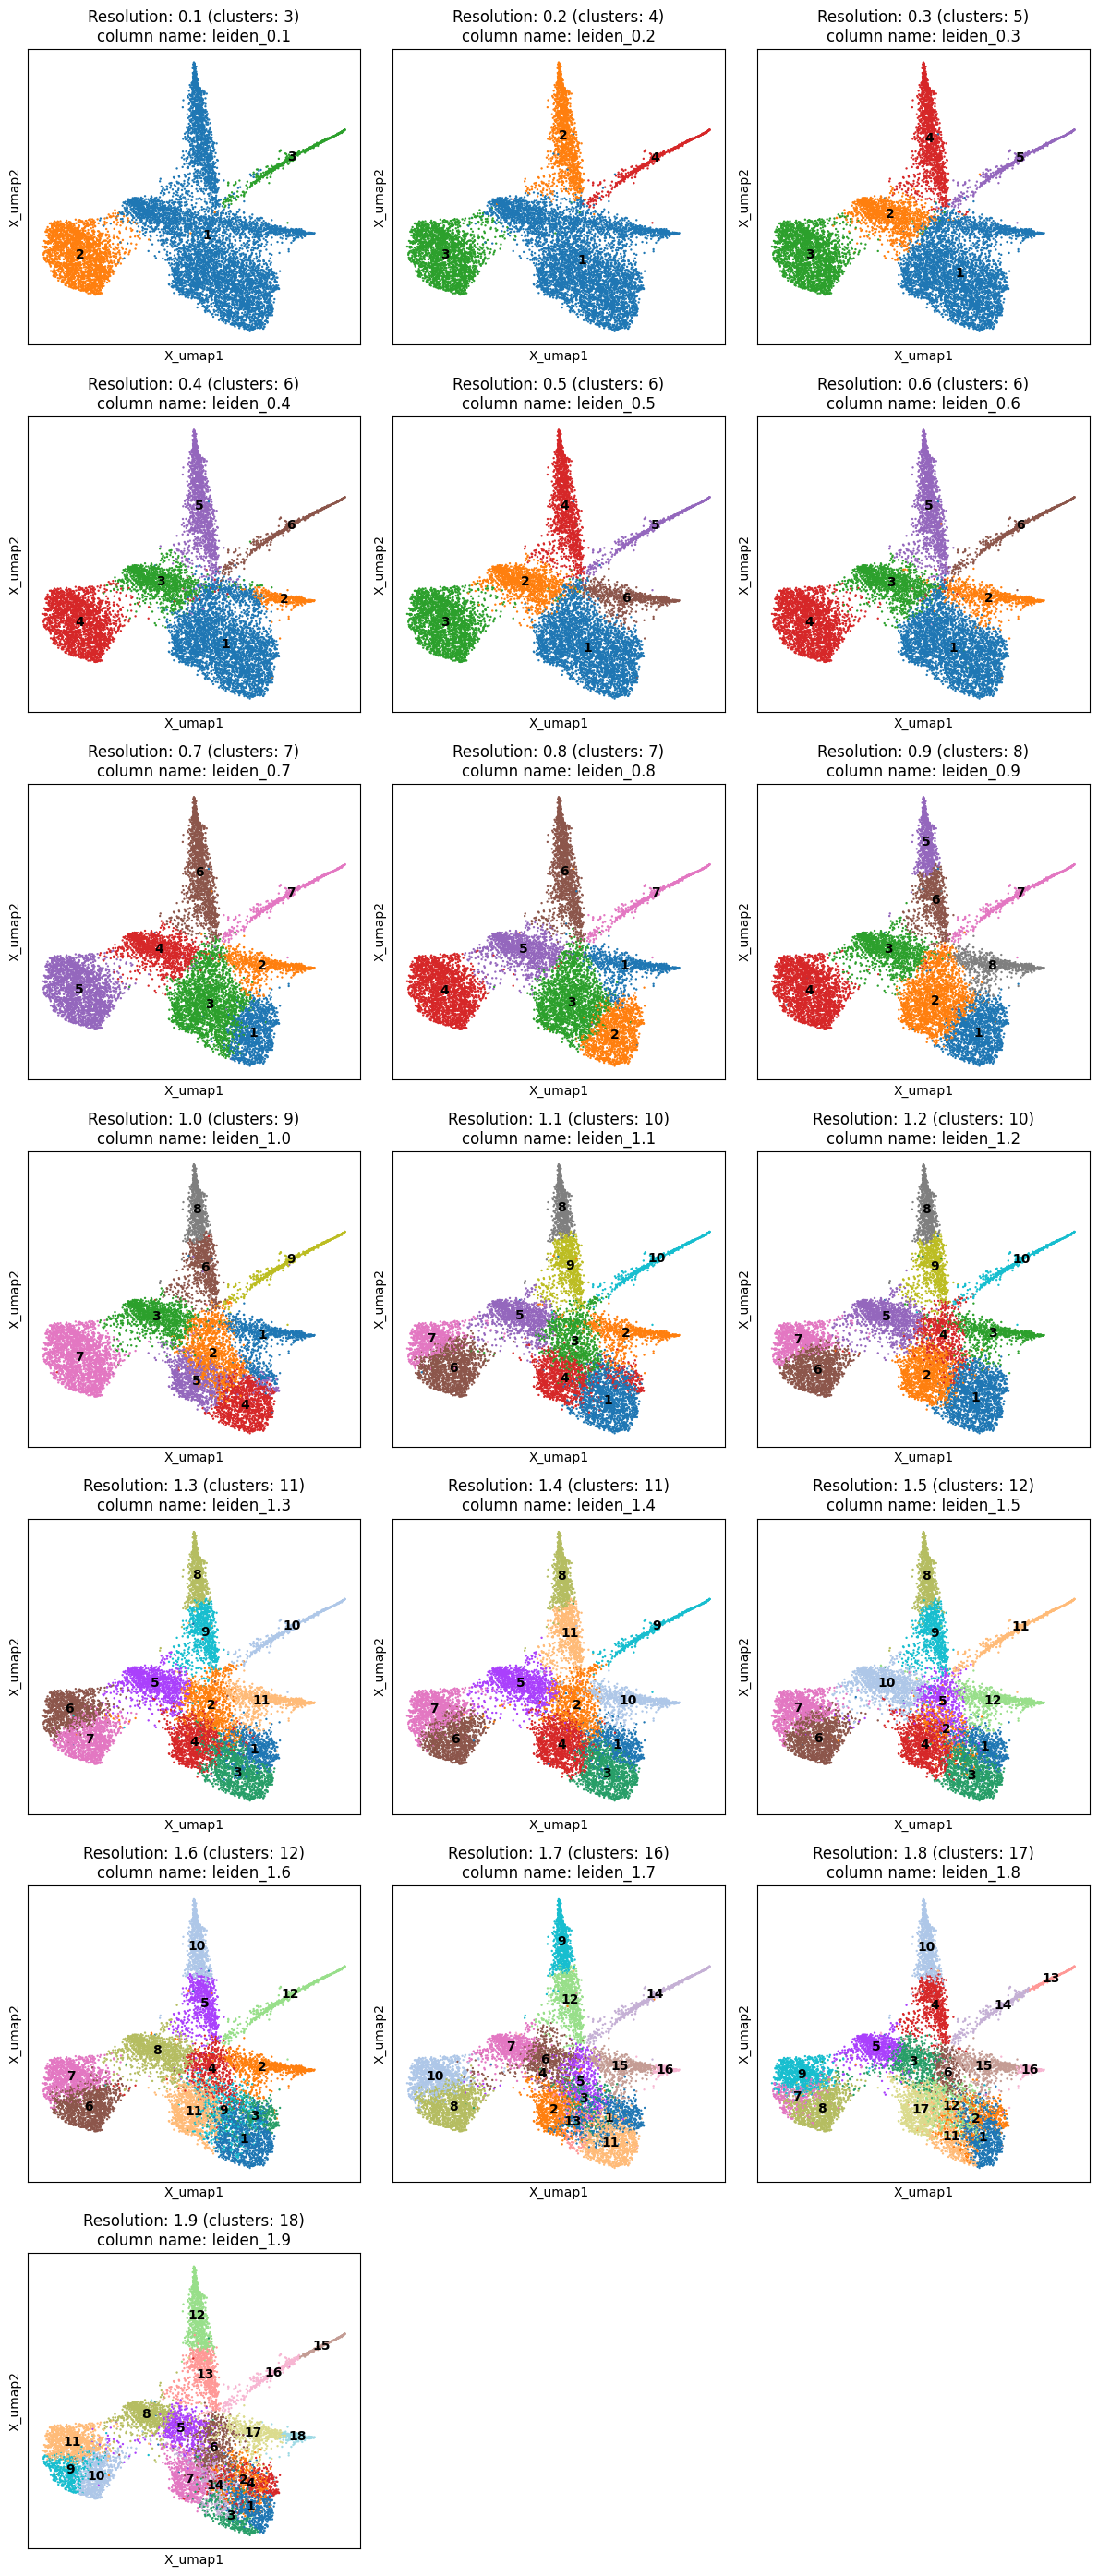

In [44]:
# plot different clustering resolutions
if search_clustering_parameters:
    pl.clustering.search_clustering_parameters(adata,
                                               ncols=cluster_ncols,
                                               method=clustering_method,
                                               resolution_range=cluster_res_range)
    plt.show()

In [45]:
# choose final resolution
clustering_column = "leiden_1.2"

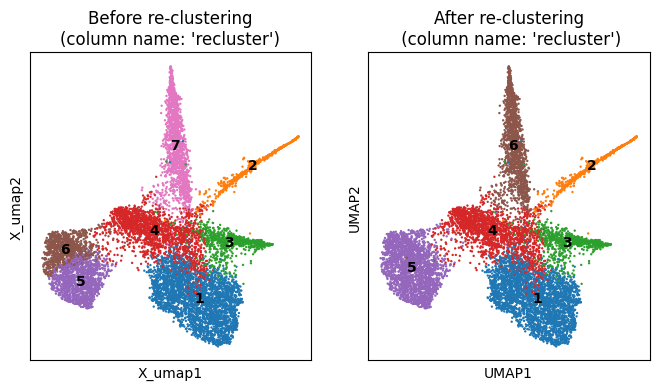

In [49]:
combine = ["6","5"]  # add cluster names

if combine:
    tools.clustering.recluster(
        adata=adata,
        column=clustering_column,
        clusters=combine,
        task="join",
        embedding=embedding,
        key_added="recluster"
    )

    clustering_column = "recluster"
    
    plt.show()

In [ ]:
split = ["2"]  # add cluster names
resolution = 0.35  # 0-1, small values create less clusters

if split:
    tools.clustering.recluster(
        adata=adata, 
        column=clustering_column,
        clusters=split,
        task="split",
        resolution=resolution,
        embedding=embedding,
        key_added="recluster"
    )

    clustering_column = "recluster"

In [50]:
 # Create final clustering
adata.obs["clustering"] = utils.tables.rename_categories(adata.obs[clustering_column])

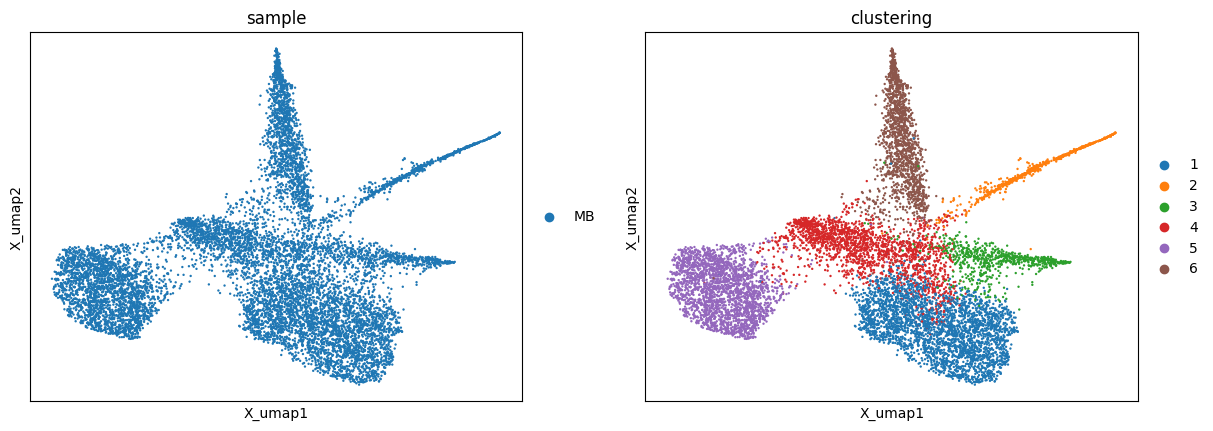

In [51]:
sc.pl.embedding(adata, basis="X_" + embedding, color=[condition_column, "clustering"], show=True)


## 9 - Quality Assesment
<hr style="border:2px solid black"> </hr>



In [ ]:
# When binarizing at the beginning normalization is introducing floats again
# Below is Done to calculate the Quality Metrics

# save a binary layer
adata.layers["processed"] = adata.X

# binarize
epi.pp.binarize(adata)
adata.layers["binary"] = adata.X

In [ ]:
add_similarity(adata, 
               distance=False, 
               n_cells=20, 
               embedding='X_umap', 
               threads=10, 
               chunksize=50, 
               highly_variable=True)

In [ ]:
distance_score = adata.obs['distance_score'].median()

In [ ]:
adata = calc_agi(adata, condition_column=clustering_column)

In [ ]:
agi_score = adata.var[clustering_column + '_' + 'gini'].dropna().mean()
n_clusters = len(adata.obs[clustering_column].unique())

In [ ]:
total_ov = sum(adata.obs['catlas_ov']) / len(adata.obs)

## Results

In [ ]:
sc.pl.embedding(adata, basis="X_" + embedding, color="catlas_ov", show=True)

In [ ]:
print(f'the fraction of cells overlapping with the CATLAS annotated cells: {total_ov}')

In [ ]:
import peakqc.insertsizes as ins
import peakqc.fld_scoring as fld

In [ ]:
only_adata_bc = list(adata.obs[adata.obs['catlas_ov'] == False].index)
fragments = f'/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/fragments/fragments_right_atrium_auricular_region_IOBHN.bed'

count_table = ins.insertsize_from_fragments(fragments=fragments, barcodes=only_adata_bc)
dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
fld.density_plot(dists_arr, colormap='gnuplot2')
fld.density_plot(fld.scale(dists_arr), colormap='gnuplot2')

In [58]:
merge_dict = {'Macrophages': ['alveolar macrophage','macrophage',],
              'Smooth-muscle-cells':['blood vessel smooth muscle cell','smooth muscle cell',],
              'T-cells': ['CD8-positive, alpha-beta T cell','mature NK T cell','naive t cell'],
              'Endothelial-cells': ['cardiac endothelial cell','endocardial cell','endothelial cell',],
              'Cardiomyocytes': ['regular atrial cardiac myocyte','ventricular cardiac muscle cell'],
              'Fibroblasts': ['fibroblast of cardiac tissue','fibroblast','skin fibroblast'],
              #'Schwann cell': ['schwann cell'],
              'Pericytes': ['pericyte cell', 'schwann cell'],
              'Fat cells': ['fat cell'],
              'Mast cells': ['mast cell'],
              'Epithelial cell': ['mesothelial cell', 'pancreatic ductal cell'],
              'other' : ['luteal cell', 'plasma cell', 'memory b cell', 'mast cell']}

# Reverse the dictionary to map celltypes to ontology
reverse_dict = {value: key for key, values in merge_dict.items() for value in values}

# Add a new column with the corresponding ontology
adata.obs['ontology'] = adata.obs['closest Cell Ontology term(s)'].map(reverse_dict)

adata.obs['ontology'].value_counts()

ontology
Fibroblasts            2714
Cardiomyocytes         2023
Endothelial-cells       777
Macrophages             411
Pericytes               290
Smooth-muscle-cells      77
T-cells                  46
Fat cells                33
other                    12
Epithelial cell           8
Name: count, dtype: int64

In [ ]:
sc.pl.embedding(adata, basis="X_" + embedding, color="ontology", show=True)

In [ ]:
adata.obs

In [ ]:
print(f'average gini index between {n_clusters} clusters: {agi_score}')

In [ ]:
sc.pl.embedding(adata, basis="X_" + embedding, color="distance_score", show=True)

In [ ]:
print(f'Embedding quality by the distance score: {distance_score}')

In [ ]:
sc.pl.embedding(adata, basis="X_" + embedding, color="n_features", show=True)

In [ ]:
# reverse overlap 
reference_h5ad =  'CATLAS_IOBHN.h5ad'

catlas_adata = sc.read_h5ad(reference_h5ad)

reference_index = catlas_adata.obs.index

reference_barcodes = []

for barcode in reference_index:
    barcode = barcode.split('+')[1]
    reference_barcodes.append(barcode)

catlas_adata.obs.index = reference_barcodes

catlas_adata.obs['catlas_ov'] = catlas_adata.obs.index.isin(adata.obs.index)

In [ ]:
sc.pl.umap(catlas_adata, color='catlas_ov')

In [ ]:
total_ov = sum(catlas_adata.obs['catlas_ov']) / len(catlas_adata.obs)
print(f'the fraction of cells overlapping: {total_ov}')

In [ ]:
sc.pl.umap(catlas_adata, color='cell type')

In [ ]:
only_adata_bc = list(catlas_adata.obs[catlas_adata.obs['catlas_ov'] == False].index)
fragments = f'/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/fragments/fragments_right_atrium_auricular_region_IOBHN.bed'

count_table = ins.insertsize_from_fragments(fragments=fragments, barcodes=only_adata_bc)
dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
fld.density_plot(dists_arr, colormap='gnuplot2')
fld.density_plot(fld.scale(dists_arr), colormap='gnuplot2')
dist_arr = None
count_table = None

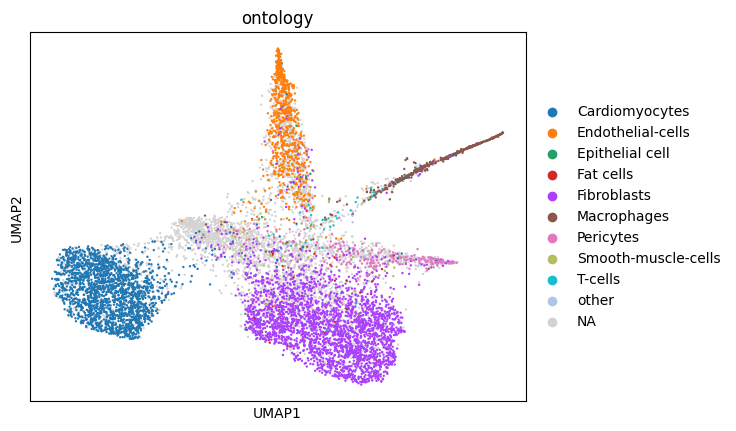

In [59]:
sc.pl.umap(adata, color='ontology')

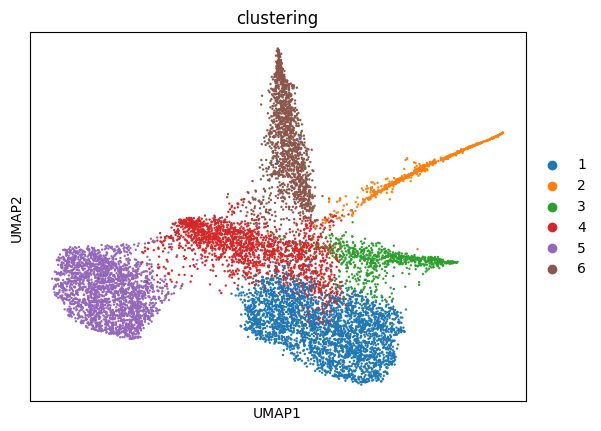

In [131]:
sc.pl.umap(adata, color='clustering', save='peakqc_100_clusters.png')

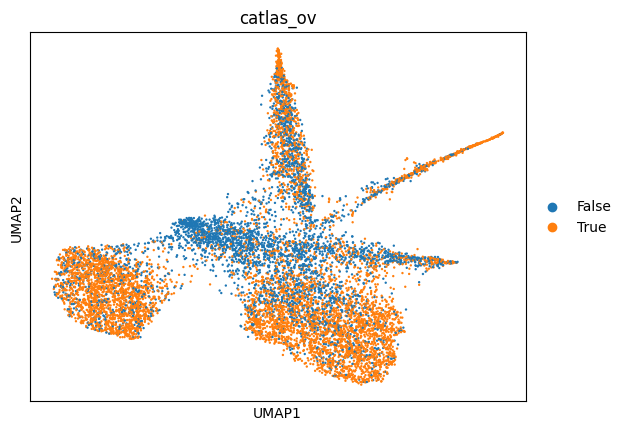

In [61]:
sc.pl.umap(adata, color='catlas_ov')

# Plot Celltype/Cluster fractions 

In [91]:
changes = {}

for i, cluster in enumerate(adata.obs['clustering'].unique()):
    counts = adata.obs[adata.obs['clustering'] == cluster].value_counts('catlas_ov')
    ontologies = adata.obs[adata.obs['clustering'] == cluster].value_counts('ontology')
    if ontologies.iloc[0]/sum(ontologies) >= 0.6:
        most_commen_ontology = ontologies.index[0]
    else:
        most_commen_ontology = 'random'
        random_subset = adata[adata.obs['clustering'] == cluster]
        
    changes[i] = {'cluster': cluster, 
                  'ontology' : most_commen_ontology, 
                  'new_cells_%' : (counts[False]/counts[True])*100,
                  'counts_ref' : counts[True],
                  'counts_new' : counts[False]}

changes = pd.DataFrame(changes).T

def stacked_histo(df, title='Title'):
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Stacked bars
    bars_ref = ax.bar(df['ontology'], df['counts_ref'], label='Counts Ref', color='skyblue')
    bars_new = ax.bar(df['ontology'], df['counts_new'], bottom=df['counts_ref'], label='Counts New', color='orange')

    # Add text for "new_cells_%" inside the upper bar
    for bar, row in zip(bars_new, df.iterrows()):
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_y() + bar.get_height() / 2, 
            f"{row[1]['new_cells_%']:.2f}%", 
            ha='center', va='center', fontsize=10, color='black'
        )

    # Labels and legend
    ax.set_xlabel("Ontology", fontsize=12)
    ax.set_ylabel("Counts", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [92]:
changes

cluster           ontology new_cells_% counts_ref counts_new
0       1        Fibroblasts   27.310749       2391        653
1       4             random  355.344418        421       1496
2       5     Cardiomyocytes   24.341085       1935        471
3       6  Endothelial-cells   84.061393        847        712
4       2        Macrophages   41.885965        456        191
5       3          Pericytes  117.251462        342        401

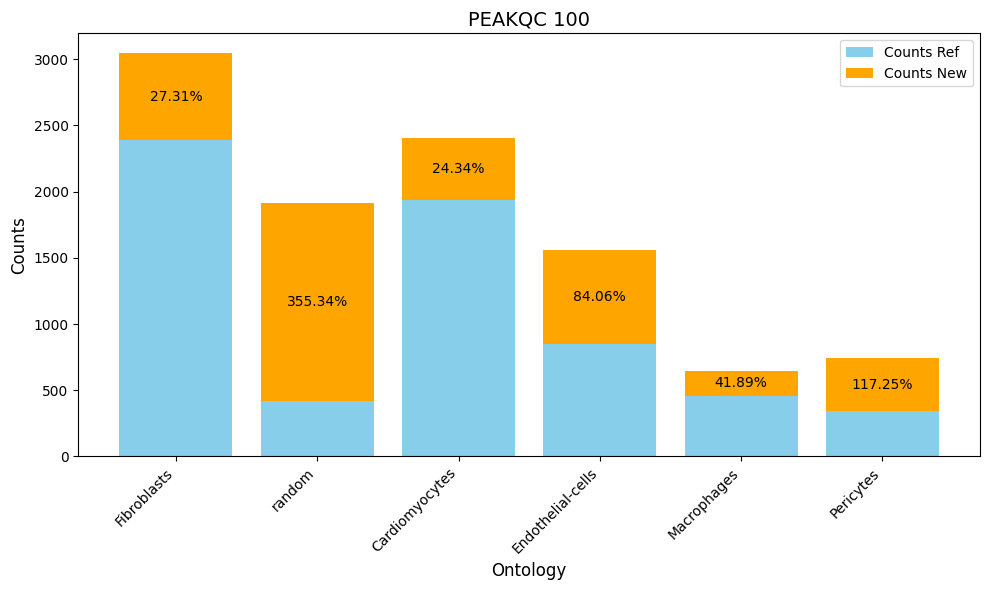

In [93]:
stacked_histo(changes,  title='PEAKQC 100')

In [94]:
sub_annotated_cells = changes[changes['cluster'].isin(annotated_clusters)]

counts_ref = sum(sub_annotated_cells['counts_ref'])
counts_new = sum(sub_annotated_cells['counts_new'])
new_cells_pct = round(np.mean(sub_annotated_cells['new_cells_%']),2)

print(f'cells in the reference: {counts_ref}')
print(f'cells new: {counts_new}')
print(f'cells new %: {new_cells_pct}')

cells in the reference: 5971
cells new: 2428
cells new %: 58.97


In [95]:
sub_annotated_cells = changes[changes['cluster'].isin(not_annotated)]

counts_ref = sum(sub_annotated_cells['counts_ref'])
counts_new = sum(sub_annotated_cells['counts_new'])
new_cells_pct = round(np.mean(sub_annotated_cells['new_cells_%']),2)

print(f'cells in the reference: {counts_ref}')
print(f'cells new: {counts_new}')
print(f'cells new %: {new_cells_pct}')

cells in the reference: 421
cells new: 1496
cells new %: 355.34


In [96]:
additional_cells = sum(~adata.obs['catlas_ov'])/sum(adata.obs['catlas_ov']) * 100
additional_cells

61.3892365456821

In [97]:
adata_name = 'fld-100.h5ad'
adata_output = '/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/filtering_qc/median/IOBHN_med/metric_specific_cells/'
utils.adata.save_h5ad(random_subset, os.path.join(adata_output, adata_name))

[INFO] The adata object was saved to: /mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/filtering_qc/median/IOBHN_med/metric_specific_cells/fld-100.h5ad


In [101]:
adata_specific = adata[adata.obs['catlas_ov'] == True]

adata_name = 'peakqc_diff.h5ad'
adata_output = '/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/filtering_qc/median/IOBHN_med/metric_specific_cells/'
utils.adata.save_h5ad(adata_specific, os.path.join(adata_output, adata_name))

[INFO] The adata object was saved to: /mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/filtering_qc/median/IOBHN_med/metric_specific_cells/peakqc_diff.h5ad


In [102]:
adata_specific

View of AnnData object with n_obs × n_vars = 6392 × 98835
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)', 'n_features', 'log1p_n_features', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'ontology', 'leiden_1.0', 'leiden_1.1', 'leiden_1.2', 'leiden_1.3', 'leiden_1.4', 'leiden_1.5', 'leiden_1.6', 'leiden_1.7', 'leiden_1.8', 'leiden_1.9', 'recluster', 'clustering'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: 'files', 'sctoolbox', 'lsi', 'pca', 'neighbors', 'umap', 'leiden_0.1', 'leiden_0.1_colors', 'leiden_0.2', 'leiden_0.2_colors', 'leiden_0.3', 'leiden_0.3_colors', 'lei

In [108]:
import peakqc.insertsizes as ins
import peakqc.fld_scoring as fld

# Plot FLD densities per Cluster

In [136]:
def density_plot(count_table,
                 max_abundance: int = 600,
                 target_height: int = 1000,
                 save= None,
                 title= 'Fragment Length Density Plot',
                 colormap: str = 'jet',
                 ax= None,
                 fig= None):
    """
    Plot the density of the fragment length distribution over all cells.

    The density is calculated by binning the abundances of the fragment lengths.

    Parameters
    ----------
    count_table : npt.ArrayLike
        Array of arrays of the fragment length distributions
    max_abundance : int, default 600
        Maximal abundance of a fragment length of a cell (for better visability)
    target_height : int, default 1000
        Target height of the plot
    save : Optional[str], default None
        If true, the figure is saved under the given name.
    colormap : str, default 'jet'
        Color map of the plot.
    ax : matplotlib.axes.Axes, default None
        Axes to plot on.
    fig : matplotlib.figure.Figure, default None
        Figure to plot on.

    Returns
    -------
    npt.ArrayLike
        Axes and figure of the plot.
    """
    count_table = count_table
    # handle 0,1 min/max scaled count_table
    if count_table.dtype != 'int64':
        if np.max(count_table) > 1:
            rounded = (np.round(count_table)).astype('int64')
            count_table = rounded
        else:
            count_table = (count_table * 1000).astype('int64')
    # get the maximal abundance of a fragment length over all cells
    max_value = np.max(np.around(count_table).astype(int))
    # Init empty densities list
    densities = []
    # loop over all fragment lengths from 0 to 1000
    for i in range(0, len(count_table[0])):
        column = count_table[:, i]
        # round abundances to be integers, that they are countable
        rounded = np.around(column).astype(int)
        # count the abundance of the abundances with boundaries 0 to maximal abundance
        gradient = np.bincount(rounded, minlength=max_value + 1)
        densities.append(gradient)
    densities = np.array(densities)

    # Log normalization + 1 to avoid log(0)
    densities_log = np.log1p(densities)

    # Transpose the matrix
    densities = densities_log.T

    # get the section of interest
    densities = densities[:max_abundance]

    # calculate the mean of the FLD
    mean = count_table.sum(axis=0) / len(count_table)

    # Stretch or compress densities' y-axis to the target height
    num_rows = densities.shape[0]
    old_y = np.linspace(0, num_rows - 1, num_rows)
    new_y = np.linspace(0, num_rows - 1, 1000)

    # Interpolate the densities along the y-axis
    densities_interpolated = np.array([np.interp(new_y, old_y, densities[:, i]) for i in range(densities.shape[1])]).T

    # scaling factor for mean
    scaling_factor = len(new_y) / len(old_y)

    # Apply the scaling factor to the mean values
    mean_interpolated = mean * scaling_factor

    # Initialize subplots
    if ax is None:
        main_plot = True
        fig, ax = plt.subplots()
    else:
        main_plot = False

    # Display the image
    im = ax.imshow(densities_interpolated, aspect='auto', origin="lower", cmap=colormap)

    # Plot additional data
    ax.plot(mean_interpolated, color="red", markersize=1)

    # Set labels and title
    ax.set_title(title)
    ax.set_xlabel('Fragment Length', color='blue')
    ax.set_ylabel('Number of Fragments', color='blue')

    # Adjust y-ticks to show original scale
    ax.set_yticks(np.linspace(0, target_height - 1, 6))
    ax.set_yticklabels(np.linspace(0, num_rows - 1, 6).astype(int))

    # Add colorbar to the plot
    if fig is not None:
        fig.colorbar(im, ax=ax, label='Density (log scale)')

    if main_plot:
        if save:
            plt.savefig(save, dpi=600)

        plt.show()

    figure = np.array([ax, fig])

    return figure

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:30,  3.80s/it]


Done reading file - elapsed time: 0:00:42
Converting counts to dataframe...
Done getting insertsizes from fragments!


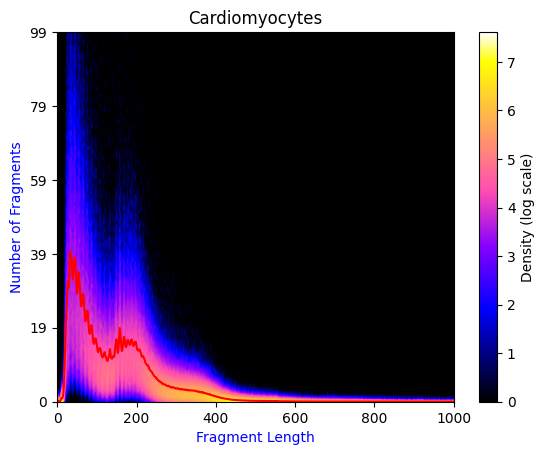

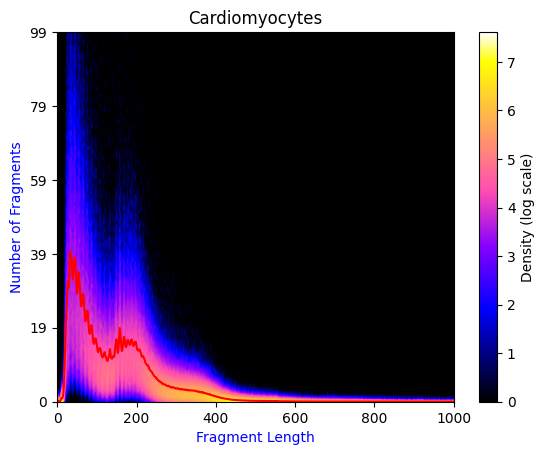

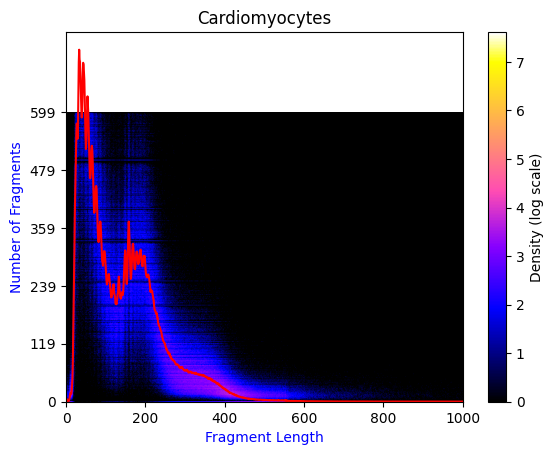

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:30,  3.80s/it]


Done reading file - elapsed time: 0:00:40
Converting counts to dataframe...
Done getting insertsizes from fragments!


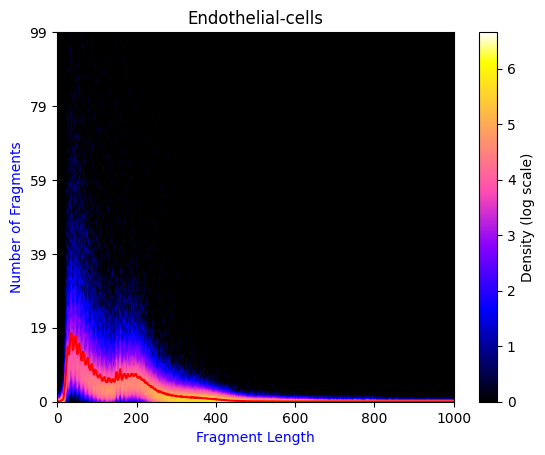

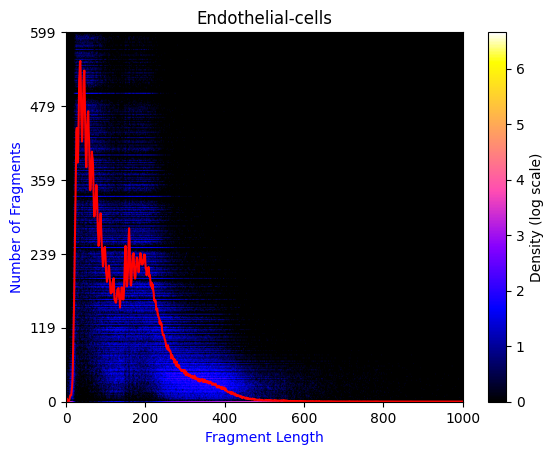

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.88s/it]


Done reading file - elapsed time: 0:00:42
Converting counts to dataframe...
Done getting insertsizes from fragments!


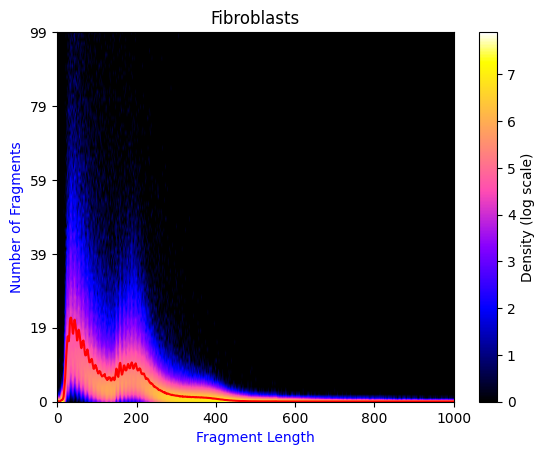

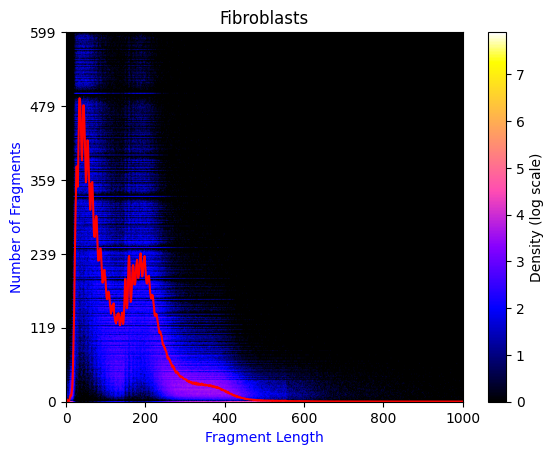

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.88s/it]


Done reading file - elapsed time: 0:00:40
Converting counts to dataframe...
Done getting insertsizes from fragments!


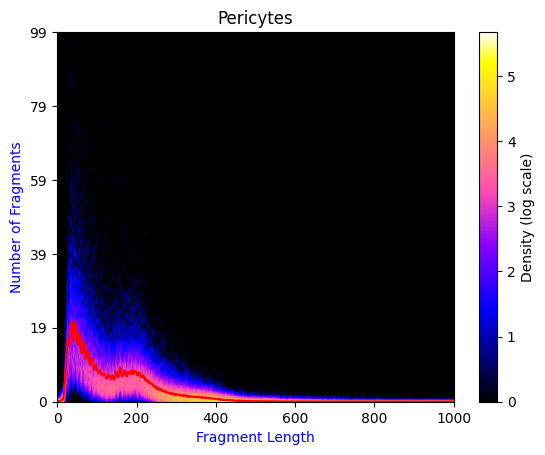

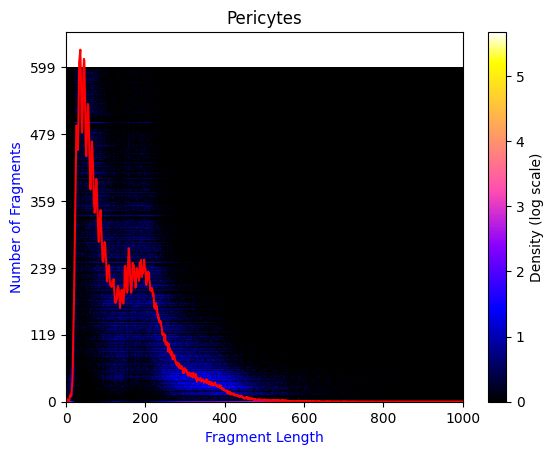

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:30,  3.79s/it]


Done reading file - elapsed time: 0:00:39
Converting counts to dataframe...
Done getting insertsizes from fragments!


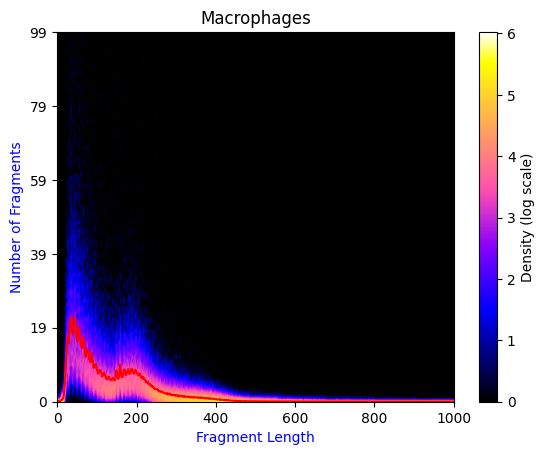

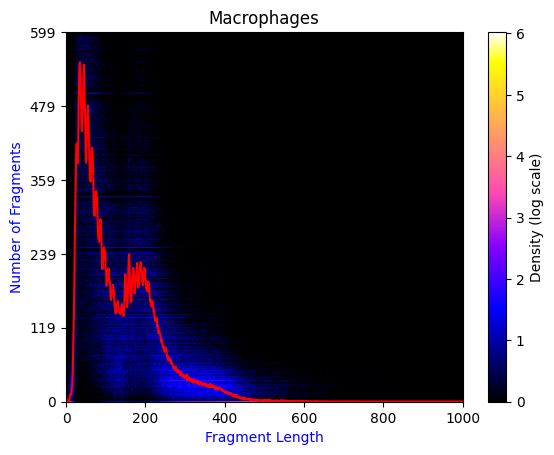

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.92s/it]


Done reading file - elapsed time: 0:00:40
Converting counts to dataframe...
Done getting insertsizes from fragments!


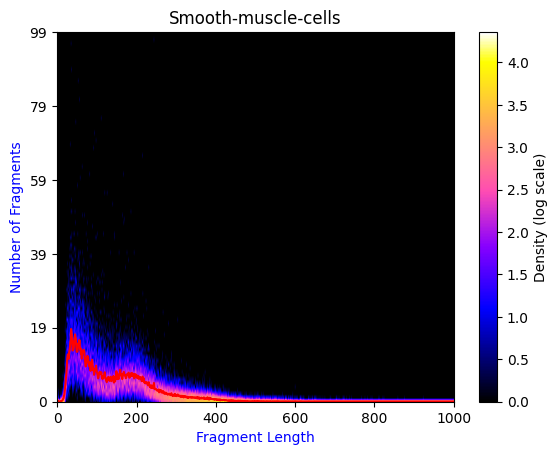

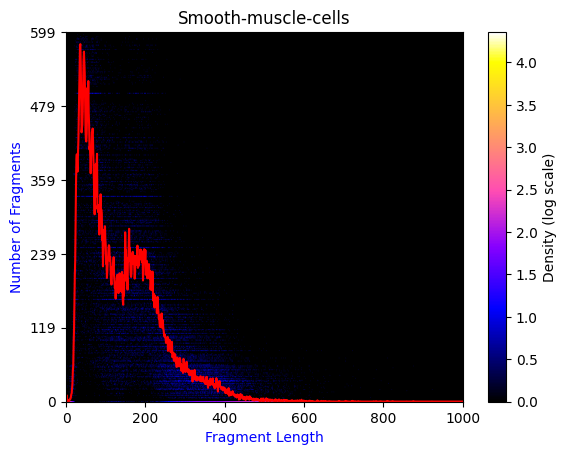

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:30,  3.86s/it]


Done reading file - elapsed time: 0:00:39
Converting counts to dataframe...
Done getting insertsizes from fragments!


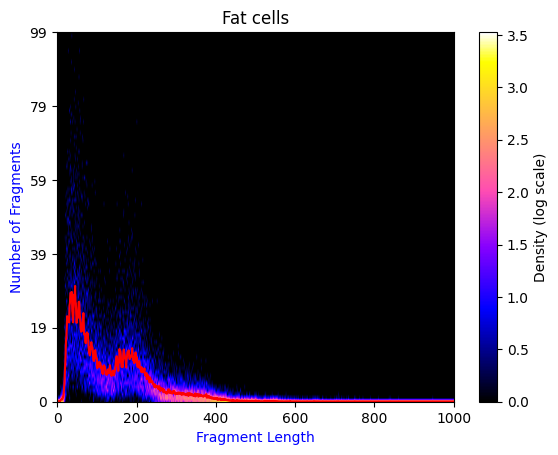

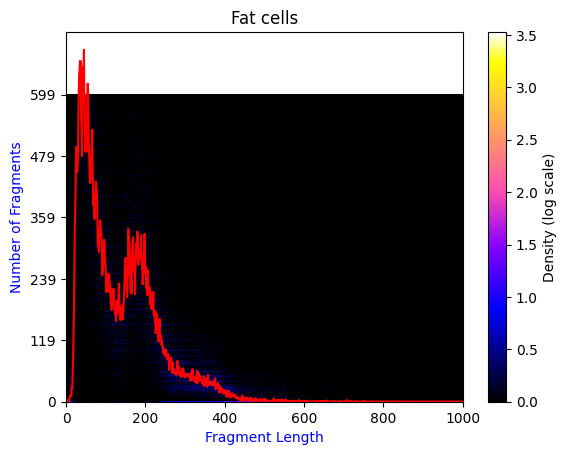

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:30,  3.79s/it]


Done reading file - elapsed time: 0:00:39
Converting counts to dataframe...
Done getting insertsizes from fragments!


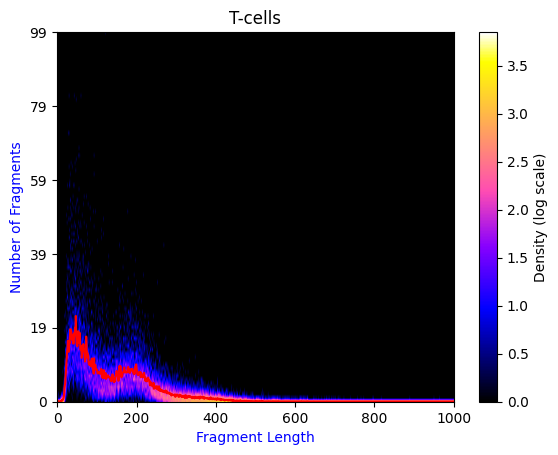

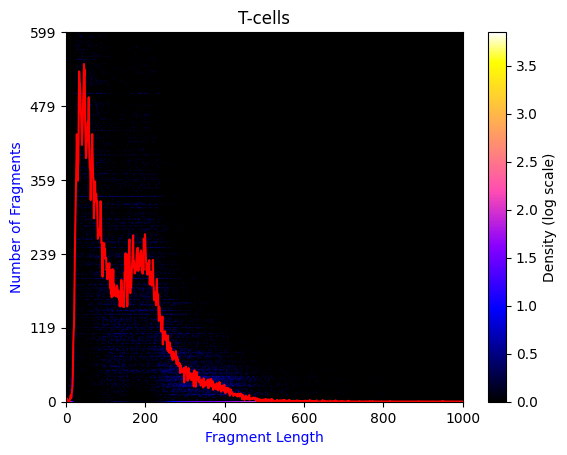

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.89s/it]


Done reading file - elapsed time: 0:00:39
Converting counts to dataframe...
Done getting insertsizes from fragments!


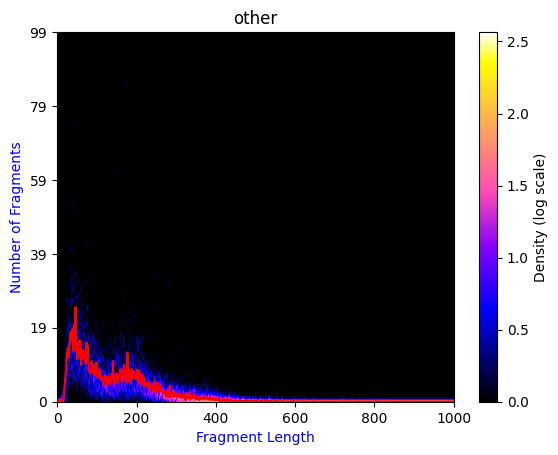

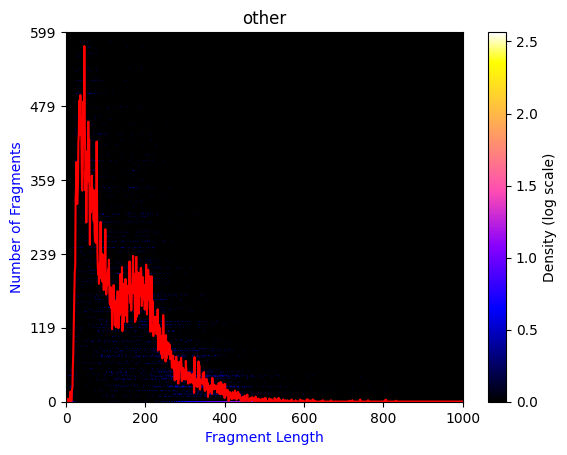

Count insertsizes from fragments...
Starting counting fragments...


Processing Chunks: 8it [00:31,  3.95s/it]


Done reading file - elapsed time: 0:00:40
Converting counts to dataframe...
Done getting insertsizes from fragments!


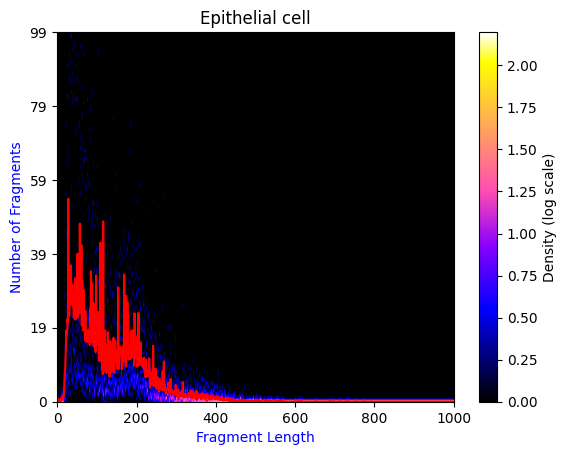

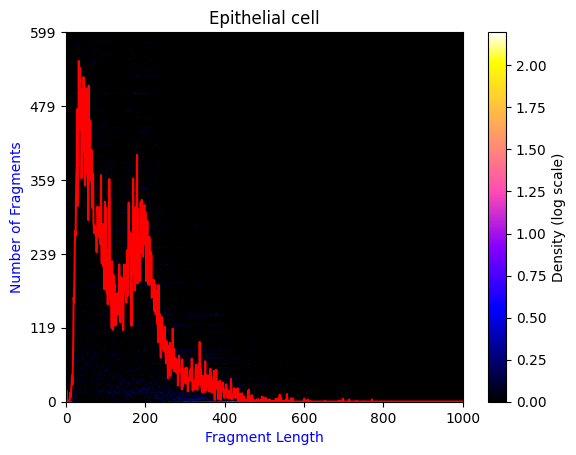

In [137]:
fragments = f'/mnt/workspace2/jdetlef/peakqc_paperprep/benchmarking/data/fragments/fragments_right_atrium_auricular_region_IOBHN.bed'

for celltype in adata.obs['ontology'].unique()[1:]:
    
    barcodes_celltype = list(adata.obs.index[adata.obs['ontology'] == celltype])

    count_table = ins.insertsize_from_fragments(fragments=fragments, barcodes=barcodes_celltype)
    dists_arr = np.array(count_table['dist'].tolist(), dtype=np.int64)
    title=celltype
    density_plot(dists_arr, colormap='gnuplot2', title=title, max_abundance=100, save=f'PEAKQC-100-{celltype}-densities.png')
    density_plot(fld.scale(dists_arr), colormap='gnuplot2', title=title)